In [195]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

seed_value = 7
sns.set_palette('coolwarm')

data_csv = pd.read_csv('../data/creditcard.csv')
data_csv['normAmount'] = StandardScaler().fit_transform(np.array(data_csv['Amount']).reshape(-1, 1))
data_csv = data_csv.drop(['Time', 'Amount'], axis=1)

data_csv.head().T

,0,1,2,3,4
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737
V3,2.536347,0.166480,1.773209,1.792993,1.548718
V4,1.378155,0.448154,0.379780,-0.863291,0.403034
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193
V6,0.462388,-0.082361,1.800499,1.247203,0.095921
V7,0.239599,-0.078803,0.791461,0.237609,0.592941
V8,0.098698,0.085102,0.247676,0.377436,-0.270533
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739
V10,0.090794,-0.166974,0.207643,-0.054952,0.753074


### Under-sampling

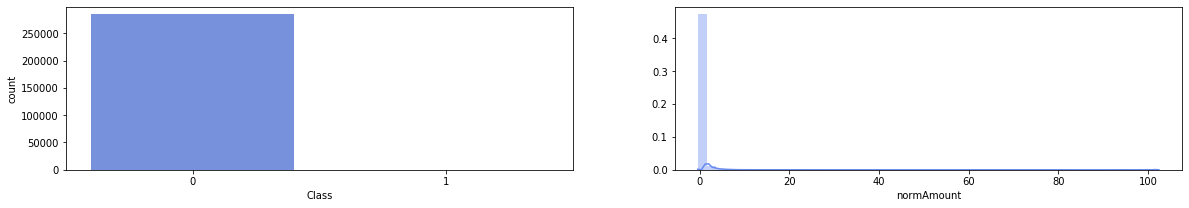

In [196]:
fig, axs = plt.subplots(1, 2, figsize=(20, 3))
sns.countplot(data_csv['Class'], ax=axs[0]);
sns.distplot(data_csv['normAmount'], ax=axs[1]);

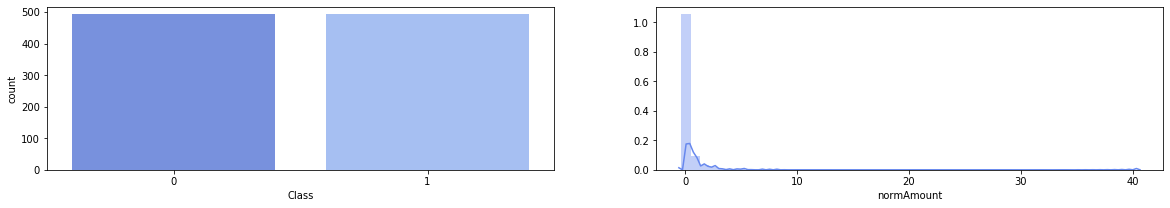

In [197]:
# Undersample so that we have equal (50/50) distribution between classes
minority_samples = data_csv[data_csv.Class == 1]
majority_samples = data_csv[data_csv.Class == 0].sample(n=minority_samples.shape[0], random_state=seed_value)

df_sampled = pd.concat([majority_samples, minority_samples])
df_sampled = df_sampled.sample(frac=1, random_state=seed_value).reset_index(drop=True)

# Plot distribution again
fig, axs = plt.subplots(1, 2, figsize=(20, 3))
sns.countplot(df_sampled['Class'], ax=axs[0]);
sns.distplot(df_sampled['normAmount'], ax=axs[1]);

In [198]:
X = df_sampled.drop('Class', axis=1).copy()
y = df_sampled.Class.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

del X
del y

## Logistic Regression

In [199]:
parameters = {
    'C':[1],
    'solver': ['liblinear'],
    'max_iter': [100],
    'random_state': [seed_value]
}

clf = GridSearchCV(LogisticRegression(), parameters, scoring='f1', cv=5)
clf.fit(X_train, y_train)

print(f'Best score {clf.best_score_:.4f} with parameters {clf.best_params_}')

Best score 0.9189 with parameters {'C': 1, 'max_iter': 100, 'random_state': 7, 'solver': 'liblinear'}


In [200]:
y_pred = clf.best_estimator_.predict(X_test)
print(f'F1 score for test set: {f1_score(y_test, y_pred):.4f}')
print(f'Recall score for test set: {recall_score(y_test, y_pred):.4f}')

F1 score for test set: 0.9765
Recall score for test set: 0.9720


## LightGBM

In [201]:
parameters = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 200],
    'random_state': [seed_value],
    'objective': ['binary']
}

clf = GridSearchCV(lgb.LGBMClassifier(), parameters, scoring='f1', cv=5)
clf.fit(X_train, y_train)

print(f'Best score {clf.best_score_:.4f} with parameters {clf.best_params_}')

Best score 0.9323 with parameters {'learning_rate': 1, 'n_estimators': 100, 'objective': 'binary', 'random_state': 7}


In [202]:
y_pred = clf.best_estimator_.predict(X_test)
print(f'F1 score for test set: {f1_score(y_test, y_pred):.4f}')
print(f'Recall score for test set: {recall_score(y_test, y_pred):.4f}')

F1 score for test set: 0.9674
Recall score for test set: 0.9720
